# NLP sentence similarity project
### Group: Sara Bonati - Irina Kokoshko

This notebook applies the Li et al. (2006) model to sentence data taken from 3 different datasets:


*   A subset of news sentence pairs from the STS benchmark, which we refer to as STS1
*   A bigger subset from the STS benchmark containing sentence pairs from news/captions/internet forums from 2012 to 2017, which we refer to as STSFull
*   Semantically ambiguous sentence pairs used in a survey online, which we refer to as Survey



In [ ]:
# general utility import
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.gridspec as gridspec
import pickle
import math
import pandas as pd
import sys,io,pprint
import re
from tqdm import tqdm

# nltk
from __future__ import division
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn, stopwords
from nltk.corpus import brown, gutenberg
from nltk.stem import WordNetLemmatizer
from nltk.data import find

#STS1 Data

### Load data

In [2]:
sts1 = pd.read_pickle("../Data/sentences_shorter.pkl")
sts1.head()

,SentenceA,SentenceB,Score
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.750
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.800
4,The tech-loaded Nasdaq composite rose 20.96 po...,The technology-laced Nasdaq Composite Index <....,2.400
5,"Amgen shares gained 93 cents, or 1.45 percent,...",Shares of Allergan were up 14 cents at $78.40 ...,1.333
7,Chavez said investigators feel confident they'...,Albuquerque Mayor Martin Chavez said investiga...,3.800


### Preprocess data + normalize semantic similarity score

In [ ]:
def preprocess_text(text):
    # convert to string
    text = str(text)
    #lowercase
    text = text.lower()
    # Clean the text
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"she\'s", "she is", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"he\'s", "he is", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\<", "", text)
    text = re.sub(r"\>", "", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    tockens = text.split(' ')
    # NO stopwords or lemmatization
    tockens = [word for word in tockens]
    return ' '.join([t for t in tockens])

for index, row in sts1.iterrows():
    sts1.loc[index, "SentenceA"] = preprocess_text(sts1.loc[index, "SentenceA"])
    sts1.loc[index, "SentenceB"] = preprocess_text(sts1.loc[index, "SentenceB"])
    if index in [0,1,2,3,4]:
        print(sts1.loc[index, "SentenceA"])
        print(sts1.loc[index, "SentenceB"])

sts1["Score"] = sts1["Score"]/5
sts1.head()

micron has declared its first quarterly profit for three years 
micron numbers also marked the first quarterly profit in three years for the dram manufacturer 
the fines are part of failed republican efforts to force or entice the democrats to return 
perry said he backs the senate efforts including the fines to force the democrats to return 
the tech loaded nasdaq composite rose 20 96 points to 1595 91 ending at its highest level for 12 months 
the technology laced nasdaq composite index ixic climbed 19 11 points or 1 2 percent to 1 615 02 


,SentenceA,SentenceB,Score
1,micron has declared its first quarterly profit...,micron numbers also marked the first quarterly...,0.7500
2,the fines are part of failed republican effort...,perry said he backs the senate efforts includi...,0.5600
4,the tech loaded nasdaq composite rose 20 96 po...,the technology laced nasdaq composite index ix...,0.4800
5,amgen shares gained 93 cents or 1 45 percent t...,shares of allergan were up 14 cents at 78 40 i...,0.2666
7,chavez said investigators feel confident they ...,albuquerque mayor martin chavez said investiga...,0.7600


### Li model class (original code from Prof. Dr. Jacobs)

In [ ]:
class Li:
    def __init__(self,alpha,beta,eta,phi,delta,dataset_name):

        # Parameters to the algorithm. Currently set to values that was reported
        # in the paper to produce "best" results.
        self.ALPHA        = alpha  # \alpha \in [0,1] -> parameter scaling the contribution of shortest path length
        self.BETA         = beta # \beta \in (0,1] -> parameter scaling the contribution of shortest path depth
        self.ETA          = eta  # word order threshold
        self.PHI          = phi  # semantic threshold
        self.DELTA        = delta # Since syntax plays a subordinate role for semantic 
        self.dataset_name = dataset_name # which dataset are we analyzing?


    ######################### word similarity ##########################

    def get_best_synset_pair(self,word_1, word_2):
        """ 
        Choose the pair with highest path similarity among all pairs. 
        Mimics pattern-seeking behavior of humans.
        """
        max_sim = -1.0
        synsets_1 = wn.synsets(word_1)
        synsets_2 = wn.synsets(word_2)
        if len(synsets_1) == 0 or len(synsets_2) == 0:
            return None, None
        else:
            max_sim = -1.0
            best_pair = None, None
            for synset_1 in synsets_1:
                for synset_2 in synsets_2:
                    sim = wn.path_similarity(synset_1, synset_2)
                    #sim = wn.wup_similarity(synset_1, synset_2)
                    if sim == None:
                        sim = 0
                    if sim > max_sim:
                        max_sim = sim
                        best_pair = synset_1, synset_2
            return best_pair
    

    def length_dist(self,synset_1, synset_2):
        """
        Return a measure of the length of the shortest path in the semantic 
        ontology (Wordnet in our case as well as the paper's) between two 
        synsets.
        """
        l_dist = sys.maxsize
        if synset_1 is None or synset_2 is None: 
            return 0.0
        if synset_1 == synset_2:
            # if synset_1 and synset_2 are the same synset return 0
            l_dist = 0.0
        else:
            wset_1 = set([str(x.name()) for x in synset_1.lemmas()])        
            wset_2 = set([str(x.name()) for x in synset_2.lemmas()])
            if len(wset_1.intersection(wset_2)) > 0:
                # if synset_1 != synset_2 but there is word overlap, return 1.0
                l_dist = 1.0
            else:
                # just compute the shortest path between the two
                l_dist = synset_1.shortest_path_distance(synset_2)
                if l_dist is None:
                    l_dist = 0.0
        # normalize path length to the range [0,1]
        return math.exp(-self.ALPHA * l_dist)
    
 
    def hierarchy_dist(self,synset_1, synset_2):
        """
        Return a measure of depth in the ontology to model the fact that 
        nodes closer to the root are broader and have less semantic similarity
        than nodes further away from the root.
        """
        h_dist = sys.maxsize
        if synset_1 is None or synset_2 is None: 
            return h_dist
        if synset_1 == synset_2:
            # return the depth of one of synset_1 or synset_2
            h_dist = max([x[1] for x in synset_1.hypernym_distances()])
        else:
            # find the max depth of least common subsumer
            hypernyms_1 = {x[0]:x[1] for x in synset_1.hypernym_distances()}
            hypernyms_2 = {x[0]:x[1] for x in synset_2.hypernym_distances()}
            lcs_candidates = set(hypernyms_1.keys()).intersection(set(hypernyms_2.keys()))
            if len(lcs_candidates) > 0:
                lcs_dists = []
                for lcs_candidate in lcs_candidates:
                    lcs_d1 = 0
                    #if hypernyms_1.has_key(lcs_candidate):
                    if (lcs_candidate) in hypernyms_1:
                        lcs_d1 = hypernyms_1[lcs_candidate]
                    lcs_d2 = 0
                    #if hypernyms_2.has_key(lcs_candidate):
                    if (lcs_candidate) in hypernyms_2:   
                        lcs_d2 = hypernyms_2[lcs_candidate]
                    lcs_dists.append(max([lcs_d1, lcs_d2]))
                h_dist = max(lcs_dists)
            else:
                h_dist = 0
        return ((math.exp(self.BETA * h_dist) - math.exp(-self.BETA * h_dist)) / 
            (math.exp(self.BETA * h_dist) + math.exp(-self.BETA * h_dist)))
    

    def word_similarity(self,word_1, word_2):
        synset_pair = self.get_best_synset_pair(word_1, word_2)
        return (self.length_dist(synset_pair[0], synset_pair[1]) * self.hierarchy_dist(synset_pair[0], synset_pair[1]))

    ######################### sentence similarity ##########################

    def most_similar_word(self,word, word_set):
        """
        Find the word in the joint word set that is most similar to the word
        passed in. We use the algorithm above to compute word similarity between
        the word and each word in the joint word set, and return the most similar
        word and the actual similarity value.
        """
        max_sim = -1.0
        sim_word = ""
        for ref_word in word_set:
            sim = self.word_similarity(word, ref_word)
            if sim > max_sim:
                max_sim = sim
                sim_word = ref_word
        return sim_word, max_sim
    
# def info_content(lookup_word):
#     """
#     Uses the Brown corpus available in NLTK to calculate a Laplace
#     smoothed frequency distribution of words, then uses this information
#     to compute the information content of the lookup_word.
#     """
#     global N
#     if N == 0:
#         # poor man's lazy evaluation
#         for sent in brown.sents():
#             for word in sent:
#                 word = word.lower()
#                 #if not brown_freqs.has_key(word):
#                 if word not in brown_freqs:
#                     brown_freqs[word] = 0
#                 brown_freqs[word] = brown_freqs[word] + 1
#                 N = N + 1
#     lookup_word = lookup_word.lower()
#     #n = 0 if not brown_freqs.has_key(lookup_word) else brown_freqs[lookup_word]
#     n = 0 if not lookup_word in brown_freqs else brown_freqs[lookup_word]
#     return 1.0 - (math.log(n + 1) / math.log(N + 1))

    def semantic_vector(self,words, joint_words, info_content_norm):
        """
        Computes the semantic vector of a sentence. The sentence is passed in as
        a collection of words. The size of the semantic vector is the same as the
        size of the joint word set. The elements are 1 if a word in the sentence
        already exists in the joint word set, or the similarity of the word to the
        most similar word in the joint word set if it doesn't. Both values are 
        further normalized by the word's (and similar word's) information content
        if info_content_norm is True.
        """
        sent_set = set(words)
        semvec = np.zeros(len(joint_words))
        i = 0
        for joint_word in joint_words:
            if joint_word in sent_set:
                # if word in union exists in the sentence, s(i) = 1 (unnormalized)
                semvec[i] = 1.0
                if info_content_norm:
                    semvec[i] = semvec[i] * math.pow(info_content(joint_word), 2)
            else:
                # find the most similar word in the joint set and set the sim value
                sim_word, max_sim = self.most_similar_word(joint_word, sent_set)
                semvec[i] = self.PHI if max_sim > self.PHI else 0.0
                #semvec[i] = max_sim if max_sim > PHI else 0.0
                if info_content_norm:
                    semvec[i] = semvec[i] * info_content(joint_word) * info_content(sim_word)
            i = i + 1
        return semvec                


    def semantic_similarity(self,sentence_1, sentence_2, info_content_norm):
        """
        Computes the semantic similarity between two sentences as the cosine
        similarity between the semantic vectors computed for each sentence.
        """
        words_1 = nltk.word_tokenize(sentence_1)
        words_2 = nltk.word_tokenize(sentence_2)
        joint_words = set(words_1).union(set(words_2))
        vec_1 = self.semantic_vector(words_1, joint_words, info_content_norm)
        vec_2 = self.semantic_vector(words_2, joint_words, info_content_norm)
        return np.dot(vec_1, vec_2.T) / (np.linalg.norm(vec_1) * np.linalg.norm(vec_2))

    ######################### word order similarity ##########################

    def word_order_vector(self,words, joint_words, windex):
        """
        Computes the word order vector for a sentence. The sentence is passed
        in as a collection of words. The size of the word order vector is the
        same as the size of the joint word set. The elements of the word order
        vector are the position mapping (from the windex dictionary) of the 
        word in the joint set if the word exists in the sentence. If the word
        does not exist in the sentence, then the value of the element is the 
        position of the most similar word in the sentence as long as the similarity
        is above the threshold ETA.
            """
        wovec = np.zeros(len(joint_words))
        i = 0
        wordset = set(words)
        for joint_word in joint_words:
            if joint_word in wordset:
                # word in joint_words found in sentence, just populate the index
                wovec[i] = windex[joint_word]
            else:
                # word not in joint_words, find most similar word and populate
                # word_vector with the thresholded similarity
                sim_word, max_sim = self.most_similar_word(joint_word, wordset)
                if max_sim > self.ETA:
                    wovec[i] = windex[sim_word]
                else:
                    wovec[i] = 0
            i = i + 1
        return wovec
    
    def word_order_similarity(self,sentence_1, sentence_2):
        """
        Computes the word-order similarity between two sentences as the normalized
        difference of word order between the two sentences.
        """
        words_1 = nltk.word_tokenize(sentence_1)
        words_2 = nltk.word_tokenize(sentence_2)
        joint_words = list(set(words_1).union(set(words_2)))
        windex = {x[1]: x[0] for x in enumerate(joint_words)}
        r1 = self.word_order_vector(words_1, joint_words, windex)
        r2 = self.word_order_vector(words_2, joint_words, windex)
        return 1.0 - (np.linalg.norm(r1 - r2) / np.linalg.norm(r1 + r2))

    ######################### overall similarity ##########################

    def similarity(self,sentence_1, sentence_2, info_content_norm):
        """
        Calculate the semantic similarity between two sentences. The last 
        parameter is True or False depending on whether information content
        normalization is desired or not.
        """
        return self.semantic_similarity(sentence_1, sentence_2, info_content_norm),\
            self.word_order_similarity(sentence_1, sentence_2),\
            self.DELTA * self.semantic_similarity(sentence_1, sentence_2, info_content_norm) + (1.0 - self.DELTA) * self.word_order_similarity(sentence_1, sentence_2)
    

    ######################### applying model to dataset ##########################
    def test_model(self,data):
        """
        Tests the Li model and returns the semantic / word order / overall Li similarity scores
        for an input dataframe "data".
        """
        # initialize scores array
        sem_results = np.zeros((len(data),1))
        ord_results = np.zeros((len(data),1))
        results     = np.zeros((len(data),1)) 

        for s in tqdm(range(len(data))):
            if self.dataset_name == "STS1" or self.dataset_name == "survey":
                s1 = str(data.iloc[s,0]) #index of sentence 1 column in dataframe
                s2 = str(data.iloc[s,1]) #index of sentence 2 column in dataframe
            elif self.dataset_name == "STSFull":
                s1 = str(data.iloc[s,5]) #index of sentence 1 column in dataframe
                s2 = str(data.iloc[s,6]) #index of sentence 2 column in dataframe
            
            sem_results[s,0],ord_results[s,0],results[s,0] = self.similarity(s1,s2,False)
        
        return pd.DataFrame({'Score_sem': sem_results[:,0],
                             'Score_ord': ord_results[:,0],
                             'Score_Li': results[:,0]})

### test model (STS1)

In [ ]:
ALPHA = 0.2  # \alpha \in [0,1] -> parameter scaling the contribution of shortest path length
BETA  = 0.45 # \beta \in (0,1] -> parameter scaling the contribution of shortest path depth
ETA   = 0.4  # word order threshold
PHI   = 0.2  # semantic threshold
DELTA = 0.85 # Since syntax plays a subordinate role for semantic

# initialize model
Li_model = Li(ALPHA,BETA,ETA,PHI,DELTA,'STS1')

# test model
res_dataframe = Li_model.test_model(sts1)
Li_model_corr = res_dataframe["Score_Li"].corr(sts1["Score"])
print(Li_model_corr)

#adding the semantic li score
sts1['Li_sem']=res_dataframe["Score_sem"]
#adding the word order li score
sts1['Li_ord']=res_dataframe["Score_ord"]
#adding final li score
sts1['Li_final']=res_dataframe["Score_Li"]


100%|██████████| 1218/1218 [16:48<00:00,  1.21it/s]

0.24052163823246087


### visualize results ( original similarity scores compared to semantic,word order and overall Li similarity scores) on a subset of STS1 sentence pairs

Text(132.0, 0.5, 'STS1 sentence pair index')

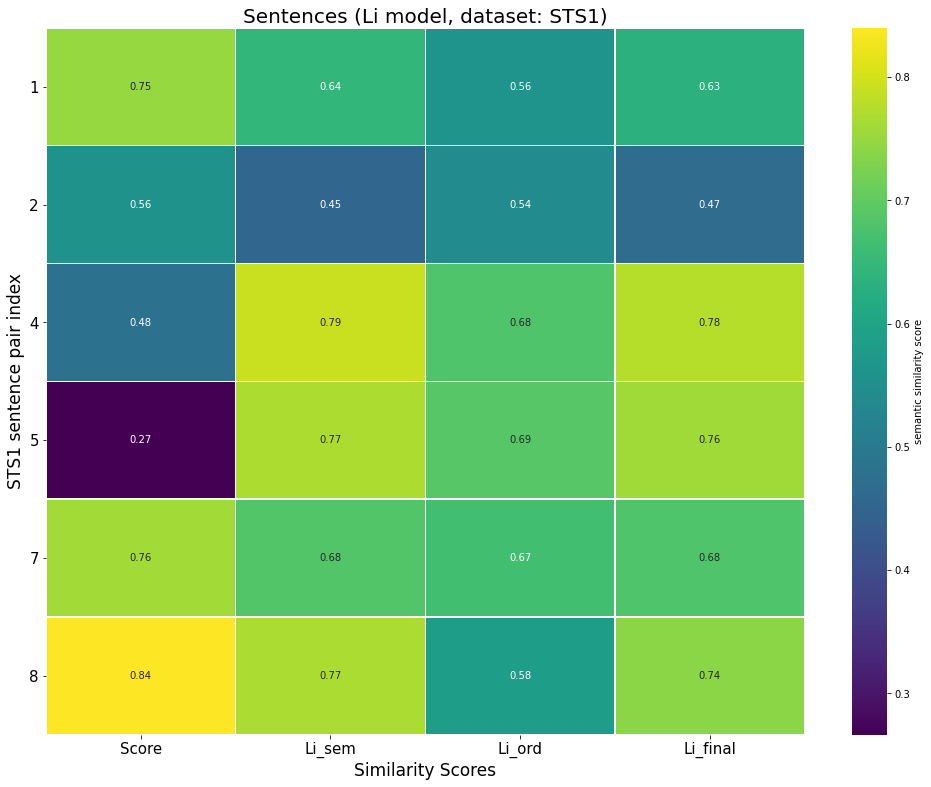

In [ ]:
#figure (sts1 sentences)
sts1_sentences = sts1.loc[:8,['Score','Li_sem','Li_ord','Li_final']]

fig1 = plt.figure(figsize=(17,13))
gs = gridspec.GridSpec(1,1)
ax={}
ax[0]=fig1.add_subplot(gs[0,0])
ax[0]=sns.heatmap(sts1_sentences, 
                  annot=True,
                  cmap='viridis',
                  linewidths=.5,
                  cbar_kws={'label': 'semantic similarity score'})
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='y',rotation=0, labelsize=15)
ax[0].set_title("Sentences (Li model, dataset: STS1)",fontsize=20)
ax[0].set_xlabel("Similarity Scores",fontsize=17)
ax[0].set_ylabel("STS1 sentence pair index",fontsize=17)

In [ ]:
for i in range(8):
    print(sts1.iloc[i,0])
    print(sts1.iloc[i,1])
    print("\n")

micron has declared its first quarterly profit for three years 
micron numbers also marked the first quarterly profit in three years for the dram manufacturer 


the fines are part of failed republican efforts to force or entice the democrats to return 
perry said he backs the senate efforts including the fines to force the democrats to return 


the tech loaded nasdaq composite rose 20 96 points to 1595 91 ending at its highest level for 12 months 
the technology laced nasdaq composite index ixic climbed 19 11 points or 1 2 percent to 1 615 02 


amgen shares gained 93 cents or 1 45 percent to 65 05 in afternoon trading on nasdaq 
shares of allergan were up 14 cents at 78 40 in late trading on the new york stock exchange 


chavez said investigators feel confident they have got at least one of the fires resolved in that regard 
albuquerque mayor martin chavez said investigators felt confident that with the arrests they had at least one of the fires resolved 


authorities said the sci

# STS Full

### load data

In [ ]:
sts_train =pd.read_csv('../Data/sts.txt',engine='python',sep='\t', quotechar='"',header=0,error_bad_lines=False)

Skipping line 1525: '	' expected after '"'
Skipping line 1542: '	' expected after '"'
Skipping line 1614: '	' expected after '"'
Skipping line 2002: '	' expected after '"'
Skipping line 2003: '	' expected after '"'
Skipping line 2006: '	' expected after '"'
Skipping line 2020: '	' expected after '"'
Skipping line 2026: '	' expected after '"'
Skipping line 2030: '	' expected after '"'
Skipping line 2031: '	' expected after '"'
Skipping line 2035: '	' expected after '"'
Skipping line 2037: '	' expected after '"'
Skipping line 2048: '	' expected after '"'
Skipping line 2055: '	' expected after '"'
Skipping line 2072: '	' expected after '"'
Skipping line 2073: '	' expected after '"'
Skipping line 2076: '	' expected after '"'
Skipping line 2080: '	' expected after '"'
Skipping line 2083: '	' expected after '"'
Skipping line 2090: '	' expected after '"'
Skipping line 2094: '	' expected after '"'
Skipping line 2096: '	' expected after '"'
Skipping line 2097: '	' expected after '"'
Skipping li

### STS Full preprocessing + normalize semantic similarity score in range (0,1)

In [ ]:
def preprocess_text(text):
    # convert to string
    text = str(text)
    #lowercase
    text = text.lower()
    # Clean the text
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text) 
    text = re.sub(r"she\'s", "she is", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"he\'s", "he is", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\<", "", text)
    text = re.sub(r"\>", "", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    tockens = text.split(' ')
    # NO stopwords or lemmatization
    tockens = [word for word in tockens]
    return ' '.join([t for t in tockens])

for index, row in sts_train.iterrows():
    sts_train.loc[index, "sent_1"] = preprocess_text(sts_train.loc[index, "sent_1"])
    sts_train.loc[index, "sent_2"] = preprocess_text(sts_train.loc[index, "sent_2"])
    if index in [0,1,2,3,4]:
        print(sts_train.loc[index, "sent_1"])
        print(sts_train.loc[index, "sent_2"])

sts_train["sim"] = sts_train["sim"]/5
sts_train.head()

a plane is taking off 
an air plane is taking off 
a man is playing a large flute 
a man is playing a flute 
a man is spreading shreded cheese on a pizza 
a man is spreading shredded cheese on an uncooked pizza 
three men are playing chess 
two men are playing chess 
a man is playing the cello 
a man seated is playing the cello 


,type,subtype,year,id,sim,sent_1,sent_2
0,main-captions,MSRvid,2012test,1,1.00,a plane is taking off,an air plane is taking off
1,main-captions,MSRvid,2012test,4,0.76,a man is playing a large flute,a man is playing a flute
2,main-captions,MSRvid,2012test,5,0.76,a man is spreading shreded cheese on a pizza,a man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,0.52,three men are playing chess,two men are playing chess
4,main-captions,MSRvid,2012test,9,0.85,a man is playing the cello,a man seated is playing the cello


Text(0.5, 0, 'sim')

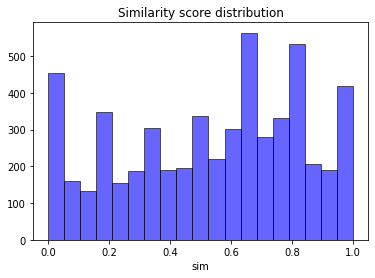

In [ ]:
plt.hist(sts_train.sim,bins='auto',color='b',alpha=0.6,edgecolor='k')
plt.title('Similarity score distribution')
plt.xlabel('sim')

### Applying Li model to data
define appropriate value ranges for all the parameters

In [ ]:
ALPHA = 0.2  # \alpha \in [0,1] -> parameter scaling the contribution of shortest path length
BETA  = 0.45 # \beta \in (0,1] -> parameter scaling the contribution of shortest path depth
ETA   = 0.4  # word order threshold
PHI   = 0.2  # semantic threshold
DELTA = 0.85 # Since syntax plays a subordinate role for semantic

# initialize model
Li_model = Li(ALPHA,BETA,ETA,PHI,DELTA,'STSFull')

# test model
res_dataframe = Li_model.test_model(sts_train)
Li_model_corr = res_dataframe["Score_Li"].corr(sts_train["sim"])
print(Li_model_corr)

100%|██████████| 5506/5506 [1:11:30<00:00,  1.28it/s]

0.5705051600625562


Text(132.0, 0.5, 'STSFull sentence pair index')

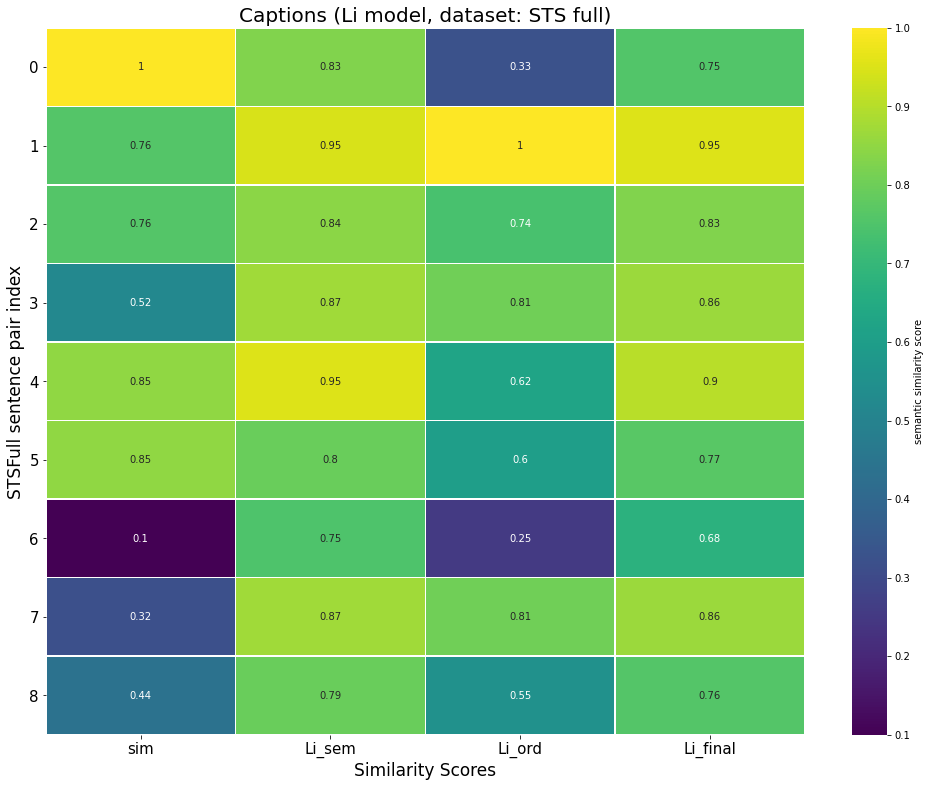

In [ ]:
#adding the semantic li score
sts_train['Li_sem']=res_dataframe["Score_sem"]
#adding the word order li score
sts_train['Li_ord']=res_dataframe["Score_ord"]
#adding final li score
sts_train['Li_final']=res_dataframe["Score_Li"]

#figure 
simple_sentences = sts_train.loc[:8,['sim','Li_sem','Li_ord','Li_final']]

fig1 = plt.figure(figsize=(17,13))
gs = gridspec.GridSpec(1,1)
ax={}
ax[0]=fig1.add_subplot(gs[0,0])
ax[0]=sns.heatmap(simple_sentences, annot=True,
                  cmap='viridis',
                  linewidths=.5,
                  cbar_kws={'label': 'semantic similarity score'})
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='y',rotation=0, labelsize=15)
ax[0].set_title("Captions (Li model, dataset: STS full)",fontsize=20)
ax[0].set_xlabel("Similarity Scores",fontsize=17)
ax[0].set_ylabel("STSFull sentence pair index",fontsize=17)

In [ ]:
for i in range(8):
    print(sts_train.iloc[i,5])
    print(sts_train.iloc[i,6])
    print("\n")

a plane is taking off 
an air plane is taking off 


a man is playing a large flute 
a man is playing a flute 


a man is spreading shreded cheese on a pizza 
a man is spreading shredded cheese on an uncooked pizza 


three men are playing chess 
two men are playing chess 


a man is playing the cello 
a man seated is playing the cello 


some men are fighting 
two men are fighting 


a man is smoking 
a man is skating 


the man is playing the piano 
the man is playing the guitar 




Text(132.0, 0.5, 'STSFull sentence pair index')

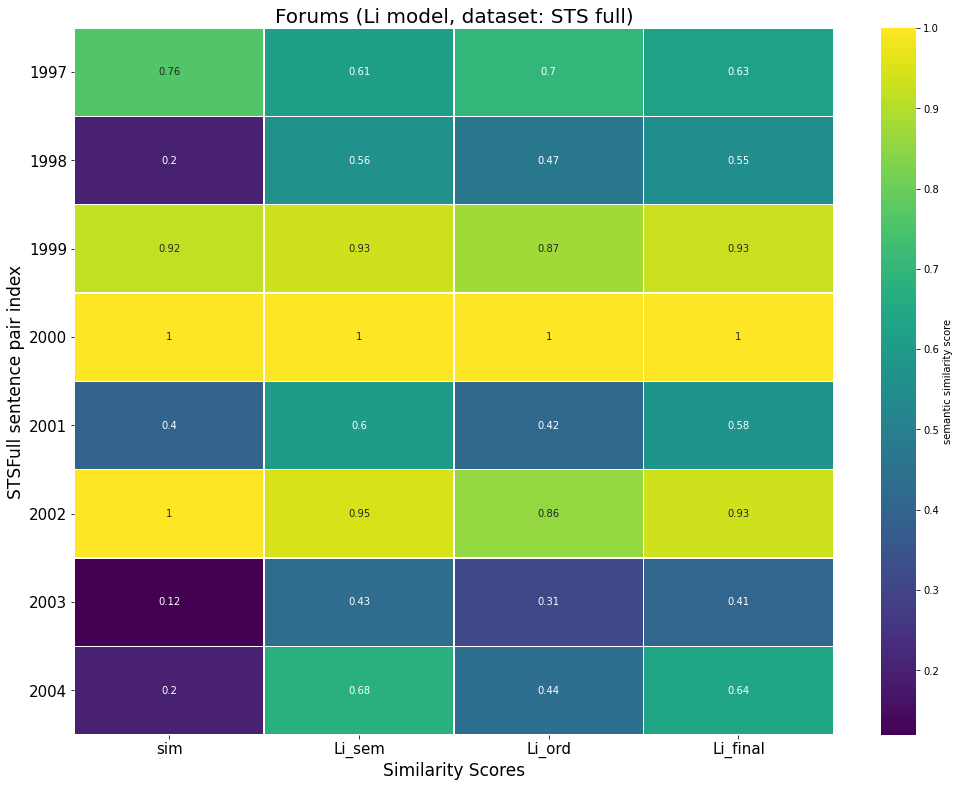

In [ ]:
# forums
#figure (forum sentences)
forum_sentences = sts_train.loc[1997:2004,['sim','Li_sem','Li_ord','Li_final']]

fig1 = plt.figure(figsize=(17,13))
gs = gridspec.GridSpec(1,1)
ax={}
ax[0]=fig1.add_subplot(gs[0,0])
#ax[0].pcolor(simple_sentences)
ax[0]=sns.heatmap(forum_sentences, annot=True, cmap='viridis',linewidths=.5,cbar_kws={'label': 'semantic similarity score'})
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='y',rotation=0, labelsize=15)
ax[0].set_title("Forums (Li model, dataset: STS full)",fontsize=20)
ax[0].set_xlabel("Similarity Scores",fontsize=17)
ax[0].set_ylabel("STSFull sentence pair index",fontsize=17)

In [ ]:
for i in range(1997,2005,1):
    print(sts_train.iloc[i,5])
    print(sts_train.iloc[i,6])
    print("\n")

the problem is simpler than that 
the problem is simple 


negative reconnaissance requirements 
pacific requirements 


go figure you are asking me to prove a negative 
you are asking me to prove a negative 


i am ok with medical use ! 
i am ok with medical use ! ! 


the prices for everything you need have gone up due to inflation 
the prices of everything you own ie assets have gone down 


war in the middle east 
a war in the middle east 


originally posted by vienna how was it authoritarian 
originally posted by zaf i give up 


imagine a place that white and black 
imagine a place with men and women 




Text(132.0, 0.5, 'STSFull sentence pair index')

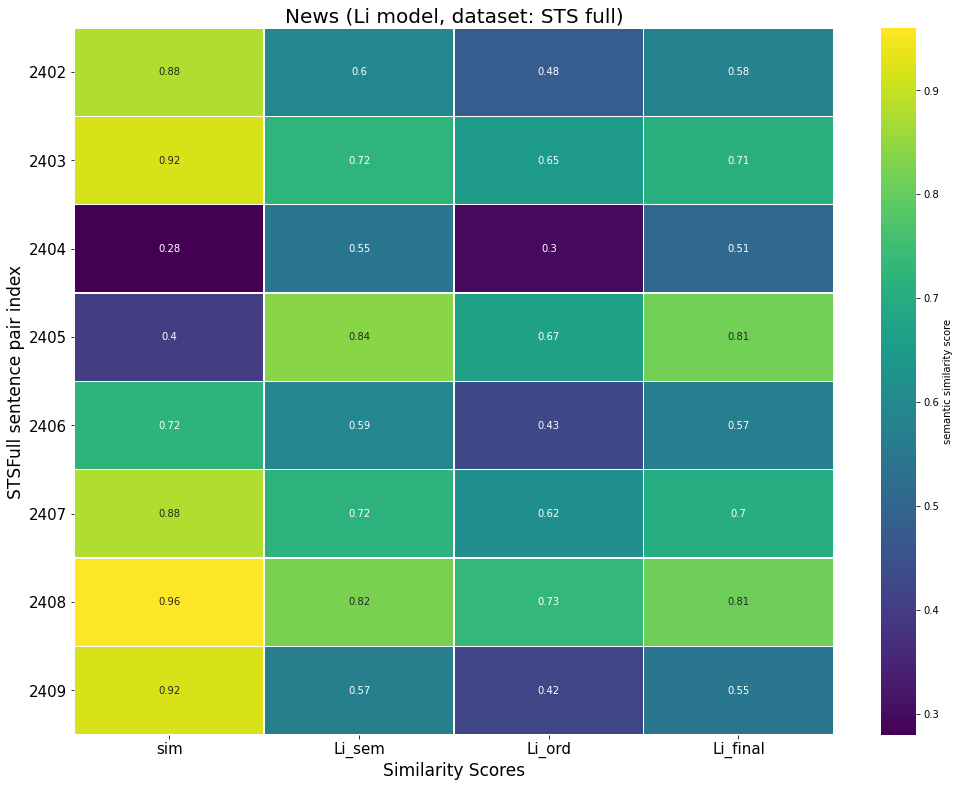

In [ ]:
#news
forum_sentences = sts_train.loc[2402:2409,['sim','Li_sem','Li_ord','Li_final']]

fig1 = plt.figure(figsize=(17,13))
gs = gridspec.GridSpec(1,1)
ax={}
ax[0]=fig1.add_subplot(gs[0,0])
#ax[0].pcolor(simple_sentences)
ax[0]=sns.heatmap(forum_sentences, annot=True, cmap='viridis',linewidths=.5,cbar_kws={'label': 'semantic similarity score'})
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='y',rotation=0, labelsize=15)
ax[0].set_title("News (Li model, dataset: STS full)",fontsize=20)
ax[0].set_xlabel("Similarity Scores",fontsize=17)
ax[0].set_ylabel("STSFull sentence pair index",fontsize=17)

In [ ]:
for i in range(2402,2410,1):
    print(sts_train.iloc[i,5])
    print(sts_train.iloc[i,6])
    print("\n")

the problem likely will mean corrective changes before the shuttle fleet starts flying again 
he said the problem needs to be corrected before the space shuttle fleet is cleared to fly again 


myanmar pro democracy leader aung san suu kyi will return home late friday but will remain in detention after recovering from surgery at a yangon hospital her personal physician said 
myanmar pro democracy leader aung san suu kyi will be kept under house arrest following her release from a hospital where she underwent surgery her personal physician said friday 


darren dopp a spitzer spokesman declined to comment late thursday 
john heine a spokesman for the commission in washington declined to comment on mr spitzer criticism 


in afternoon trading in europe france cac 40 advanced and britain ftse 100 each gained 0 7 percent while germany dax index rose 0 6 percent 
in europe france cac 40 rose 1 3 percent britain ftse 100 declined 0 2 percent and germany dax index gained 0 6 percent 


sens j

#Survey dataset

## Load data

In [ ]:
#load data
#-------------------------------------------------------------------------------
# dataset survey
survey      = pd.read_pickle("../Data/survey.pkl")

## Preprocess data

In [ ]:
for index, row in survey.iterrows():
    survey.loc[index, "sent_1"] = preprocess_text(survey.loc[index, "sent_1"])
    survey.loc[index, "sent_2"] = preprocess_text(survey.loc[index, "sent_2"])

## Apply Li model to Survey

In [ ]:
ALPHA = 0.2  # \alpha \in [0,1] -> parameter scaling the contribution of shortest path length
BETA  = 0.45 # \beta \in (0,1] -> parameter scaling the contribution of shortest path depth
ETA   = 0.4  # word order threshold
PHI   = 0.2  # semantic threshold
DELTA = 0.85 # Since syntax plays a subordinate role for semantic

# initialize model
Li_model = Li(ALPHA,BETA,ETA,PHI,DELTA,'survey')

# test model
res_dataframe = Li_model.test_model(survey)
Li_model_corr = res_dataframe["Score_Li"].corr(survey["score"])
print(Li_model_corr)

# Additional: Li model parameter grid search (done over STS1)

While a value of $\delta=0.85$ seems reasonable to quantify the different impact , we test whether different $(\alpha,\beta,\eta,\phi)$ parameter values can improve the Li model performance. We perform 2 grid searches for the STS1 dataset over best parameter values for the Li model, namely 
- A grid search over parameters $(\alpha,\beta)$ where the parameter space considered is $\alpha = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]$ and $\beta = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]$
- A grid search over parameters $(\eta,\phi)$ where the parameter space considered is $\eta = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]$ and $\phi = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]$

**NOTE 1:** This cell taks a long time to complete and might not even finish to be run, depending on colab runtime threshold.

**NOTE 2:** While a better parameter grid search should be performed exploring parameter space of all parameters at once, due to the long time required to finish such a grid search here we decided to perform just two "smaller" grid searches. In the following we splitted the grid search in different searches varying the parameter values due to colab not allowing more runtime than a certain threshold. Results from these splits are then merged together and shown in a separate colab file.

Grid search over best parameter values $(\alpha$ and $\beta)$

In [ ]:
# path length and depth parameters
param_res     = 10
A             = np.arange(0,1.1,1/param_res) 
B             = np.arange(0.1,1.1,1/param_res)
ALPHAS, BETAS = np.meshgrid(A, B, sparse=False, indexing='ij')
ETA           = 0.4  # word order threshold
PHI           = 0.2  # semantic threshold
DELTA         = 0.85 # Since syntax plays a subordinate role for semantic

Li_scores     = np.zeros((len(A),len(B))) #correlation scores

for i in range(len(A)):
    for j in range(len(B)):
        Li_model       = Li(ALPHAS[i,j], BETAS[i,j],ETA,PHI,DELTA,'STS1')
        res            = Li_model.test_model(sts1) 
        Li_scores[i,j] = res["Score_Li"].corr(sts1["Score"])

# figure initialization
gridsearchAB = plt.figure(figsize=(10,10))
gs=gridspec.GridSpec(1,1)
ax={}

ax[0]=gridsearchAB.add_subplot(gs[0,0])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)

img = ax[0].imshow(Li_scores,origin='lower',cmap='viridis')
i,j = np.unravel_index(Li_scores.argmax(), Li_scores.shape)
ax[0].scatter(j,i,color='r',marker='x',s=140,label='max$(r)$')
ax[0].set_ylabel(r"$\alpha$",rotation=0,fontsize=15,labelpad=10)
ax[0].set_xlabel(r"$\beta$",fontsize=15)
ax[0].set_xticks([i for i in range(10)])
ax[0].set_yticks([i for i in range(11)])
ax[0].set_xticklabels([str(round(i,2)) for i in np.arange(0.1,1.1,1/10)])
ax[0].set_yticklabels([str(round(i,2)) for i in np.arange(0,1.1,1/10)])
ax[0].set_title(r"Grid search over $(\alpha,\beta)$ (other parameters kept fixed)",fontsize=16)
ax[0].legend(loc='best',fontsize=13)

# colorbar settings
cbar = gridsearchAB.colorbar(img, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Correlation $(r)$', rotation=270,fontsize=15)
plt.show()

Grid search over best parameter values $(\phi$ and $\eta)$

In [ ]:
param_res     = 10
P             = np.arange(0,1.1,1/param_res) 
E             = np.arange(0,1.1,1/param_res)
PHIS, ETAS    = np.meshgrid(P, E, sparse=False, indexing='ij')

Li_scores     = np.zeros((len(P),len(P))) #correlation scores

for i in range(len(P)):
    for j in range(len(P)):
        Li_model       = Li(ALPHAS[i,j], BETAS[i,j],ETA,PHI,DELTA,'STS1')
        res            = Li_model.test_model(data) 
        Li_scores[i,j] = res["Score_Li"].corr(data["Score"])

# plot
# figure initialization
gridsearchEP = plt.figure(figsize=(10,10))
gs=gridspec.GridSpec(1,1)
ax={}

ax[0]=gridsearchEP.add_subplot(gs[0,0])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)

img = ax[0].imshow(Li_scores,origin='lower',cmap='viridis')
i,j = np.unravel_index(Li_scores.argmax(), Li_scores.shape)
ax[0].scatter(j,i,color='r',marker='x',s=140,label='max$(r)$')
ax[0].set_ylabel(r"$\eta$",rotation=0,fontsize=15,labelpad=10)
ax[0].set_xlabel(r"$\phi$",fontsize=15)
ax[0].set_xticks([i for i in range(11)])
ax[0].set_yticks([i for i in range(11)])
ax[0].legend(loc='best',fontsize=13)
ax[0].set_xticklabels([str(round(i,2)) for i in np.arange(0,1.1,1/10)])
ax[0].set_yticklabels([str(round(i,2)) for i in np.arange(0,1.1,1/10)])
ax[0].set_title(r"Grid search over $(\eta,\phi)$ (other parameters kept fixed)",fontsize=16)
# colorbar settings
cbar = gridsearchAB.colorbar(img, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Correlation $(r)$', rotation=270,fontsize=15)
plt.show()